In [1]:
from pitas import power, flipper_tools
from orphics import maps as omaps
from pixell import enplot, enmap, curvedsky
import numpy as np
from cosmikyu import stats, mpi, datasets, config, utils, gan, transforms
from cosmikyu import nn as cnn
import os
from itertools import product
import healpy as hp
import matplotlib.pyplot as plt
import random
from minkfncts2d import MF2D
from itertools import cycle

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
data_dir = config.default_data_dir
sehgal_dir = os.path.join(data_dir, 'sehgal')
stat_dir = os.path.join(sehgal_dir, "stats")

norm_info_file = "/home/dwhan89/workspace/cosmikyu/data/sehgal/201020_logzshrink_normalization_info_validation.npz"
SDN = transforms.SehgalDataNormalizerScaledLogZShrink(norm_info_file)
SUN = transforms.SehgalDataUnnormalizerScaledLogZShrink(norm_info_file)
compts = ["kappa", "ksz", "tsz", "ir", "rad"]

plot_dir = "/home/dwhan89/scratch/outbox/cosmikyu"
def plot_path(x):
    return os.path.join(plot_dir, x)

/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
overwrite=False
STAT_TEST = stats.STATS("sehgal_cosmoganwgpv_minko", output_dir=stat_dir, overwrite=overwrite)

SDS_test = datasets.SehgalDataSet(sehgal_dir, data_type="test141020", transforms=[SDN], dummy_label=False)
nsample = 100#len(SDS_test)

z = np.linspace(-30,30,300)
for i, compt in enumerate(compts):
    for j in range(nsample):
        if j % 100 == 0: print(compt, j)
        st_idx_temp = "%s_{}"%compt
        if STAT_TEST.has_data(st_idx_temp.format("chi"), j):
            continue
        for k, threshold in enumerate(z):
            f, u, chi = MF2D(SDS_test[j][i], threshold)
            storage[k,:] = np.array([f, u, chi])
        STAT_TEST.add_data(st_idx_temp.format("f"), j, storage[:,0].copy())
        STAT_TEST.add_data(st_idx_temp.format("u"), j, storage[:,1].copy())    
        STAT_TEST.add_data(st_idx_temp.format("chi"), j, storage[:,2].copy())
            
STAT_TEST.add_data("z", 0, z)
ret = STAT_TEST.get_stats()    

[STATS] output_dir is /home/dwhan89/workspace/cosmikyu/cosmikyu/../data/sehgal/stats
[STATS] loaded /home/dwhan89/workspace/cosmikyu/cosmikyu/../data/sehgal/stats/stats_sehgal_cosmoganwgpv_minko.npz


TypeError: __init__() got an unexpected keyword argument 'data_type'

In [ ]:
STanh = cnn.ScaledTanh(30., 2./30.)
LF = cnn.LinearFeature(5,5)
MCM = transforms.MultiComptMultiply([1, 0.9991, 0.9834, 0.9894, 1.0034]  )

norm_info_file = "/home/dwhan89/workspace/cosmikyu/data/sehgal/201020_logzshrink_normalization_info_validation.npz"
experiment_id = "63101414f2434a3e93cd28663a89f879"
model_dir = "/home/dwhan89/workspace/cosmikyu/output/sehgal_dcganwgp_211020/{}/model".format(experiment_id)
print(model_dir)
latent_dim = 256
overwrite =True
SDN = transforms.SehgalDataNormalizerScaledLogZShrink(norm_info_file)
SUN = transforms.SehgalDataUnnormalizerScaledLogZShrink(norm_info_file)
STAT_GEN = stats.STATS(experiment_id+"_minko", output_dir=stat_dir, overwrite=overwrite)
save_points = np.arange(0,3,1)
shape = (128,128)
nsample = 100

z = np.linspace(-30,30,300)
for save_point in save_points: 
    DCGAN_WGP = gan.DCGAN_WGP("sehgal_dcganwgp", (5,)+shape, latent_dim, cuda=False, nconv_fcgen=64,
                                      nconv_fcdis=64, ngpu=4, nconv_layer_gen=5, nconv_layer_disc=5, 
                              kernal_size=4, stride=2, padding=1, output_padding=0, gen_act=[LF,STanh])
    DCGAN_WGP.load_states(model_dir, "_{}".format(save_point))
    
    for i, compt in enumerate(compts):
        for j in range(nsample):
            if j % 6000 == 0: print(compt, j)
            st_idx_temp = "%s_%s_{}"%(compt, save_point)
            
            #if STAT_GEN.has_data(st_idx_temp.format("chi"), j):
                #continue
            
            sample = MCM(DCGAN_WGP.generate_samples(1).data.numpy()[0].astype(np.float64))
            plt.show()
            storage = np.zeros((len(z), 3))
            for k, threshold in enumerate(z):
                f, u, chi = MF2D(sample[i], threshold)
                storage[k,:] = np.array([f, u, chi])
            
            STAT_GEN.add_data(st_idx_temp.format("f"), j, storage[:,0].copy())
            STAT_GEN.add_data(st_idx_temp.format("u"), j, storage[:,1].copy())    
            STAT_GEN.add_data(st_idx_temp.format("chi"), j, storage[:,2].copy())

    STAT_GEN.add_data("z", 0, z)
ret = STAT_GEN.get_stats()  

In [4]:
def key2label(key):
    storage = {"kappa":r"$  \kappa  $",
               "ksz":" kSZ ",
               "tsz":" tSZ ",
               "ir":" CIB ",
               "rad":"Radio",
              }
    return storage[key]

<>:9: DeprecationWarning: invalid escape sequence \c
<>:9: DeprecationWarning: invalid escape sequence \c
<>:9: DeprecationWarning: invalid escape sequence \c
<ipython-input-5-77845209fca0>:9: DeprecationWarning: invalid escape sequence \c
  label="$\chi$ (Euler characteristic)", color="g")


NameError: name 'z' is not defined

<Figure size 432x288 with 0 Axes>

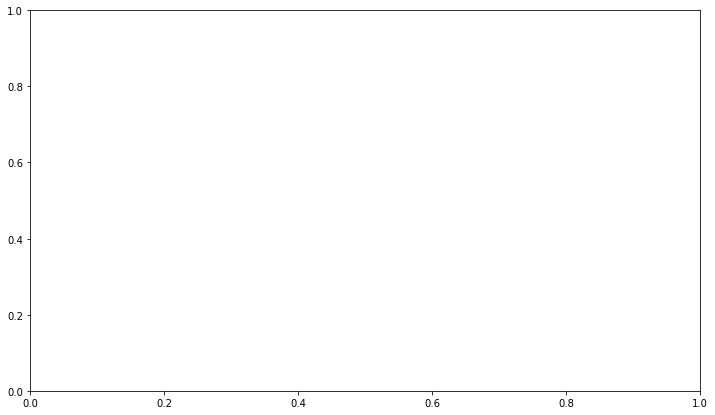

In [5]:

for i, compt in enumerate(compts):
    plt.clf()
    st_idx_temp = "%s_{}"%(compt)
    fig = plt.figure(figsize=(12,7))
    ax = fig.gca()
    plt.plot(z, STAT_TEST.stats[st_idx_temp.format("f")]["mean"], alpha=0.5, lw=3, label="F (Area)", color="r")
    plt.plot(z, STAT_TEST.stats[st_idx_temp.format("u")]["mean"], alpha=0.5,lw=3, label="U (Boundary)", color="b")
    plt.plot(z, STAT_TEST.stats[st_idx_temp.format("chi")]["mean"], alpha=0.5,lw=3,
             label="$\chi$ (Euler characteristic)", color="g")
    st_idx_temp = "%s_%s_{}"%(compt, save_points[0])
    mean, std = STAT_GEN.stats[st_idx_temp.format("f")]["mean"], STAT_GEN.stats[st_idx_temp.format("f")]["std"]
    plt.plot(z, mean, ls="--", lw=3, color="r")
    mean, std = STAT_GEN.stats[st_idx_temp.format("u")]["mean"], STAT_GEN.stats[st_idx_temp.format("u")]["std"]
    plt.plot(z, mean, ls="--", lw=3, color="b")
    mean, std = STAT_GEN.stats[st_idx_temp.format("chi")]["mean"], STAT_GEN.stats[st_idx_temp.format("chi")]["std"]
    plt.plot(z, mean, ls="--", lw=3, color="g")
    plt.plot([],[], lw=3, color="k", label="Reference")
    plt.plot([],[], ls="--", lw=3, color="k", label="Generated")
    plt.xlim(-5,5)
    plt.yscale("linear")
    plt.legend(fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=22)
    ax.tick_params(axis='both', which='minor', labelsize=22)
    plt.xlabel("Threshold", fontsize=20)
    plt.show()

0 0 0


/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:11: DeprecationWarning: invalid escape sequence \c
<>:35: DeprecationWarning: invalid escape sequence \c
<>:11: DeprecationWarning: invalid escape sequence \c
<>:35: DeprecationWarning: invalid escape sequence \c
<>:11: DeprecationWarning: invalid escape sequence \c
<>:35: DeprecationWarning: invalid escape sequence \c
<ipython-input-44-200477c952cf>:11: DeprecationWarning: invalid escape sequence \c
  label="$\chi$ (Euler characteristic)", color="g")
<ipython-input-44-200477c952cf>:35: DeprecationWarning: invalid escape sequence \c
  axes[2,1].plot([],[], lw=3, color="g", label="$\chi$ (Euler characteristic)")


KeyError: 'kappa_f'

<Figure size 432x288 with 0 Axes>

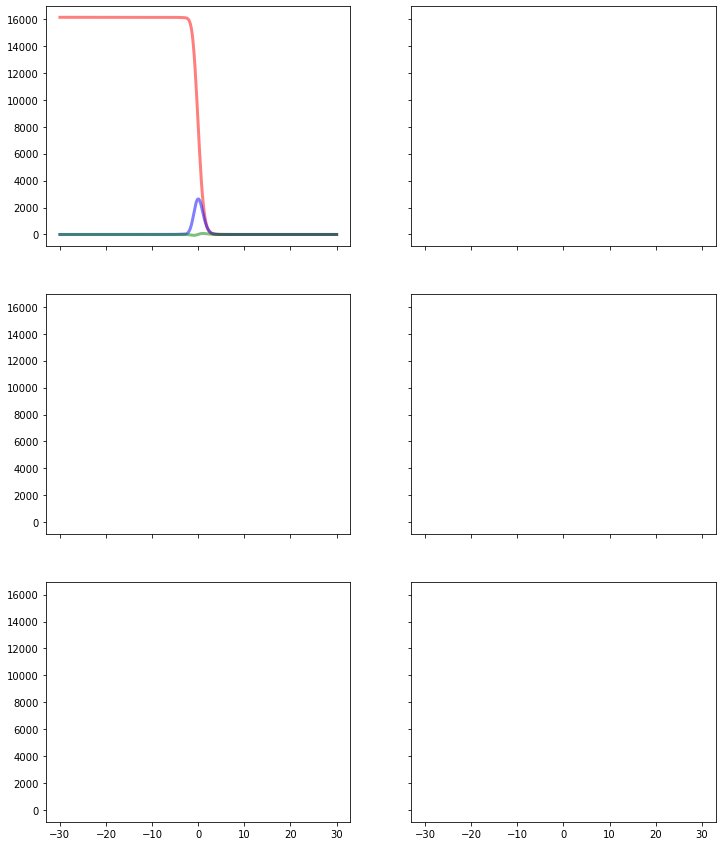

In [44]:
plt.clf()
fig, axes = plt.subplots(3,2, figsize=(12,15), sharex='all', sharey='all')
for i, compt in enumerate(compts):
    yidx = i // 2
    xidx = i % 2
    print(i, yidx, xidx)
    st_idx_temp = "%s_{}"%compt
    axes[yidx,xidx].plot(z, STAT_TEST.stats[st_idx_temp.format("f")]["mean"], alpha=0.5, lw=3, label="F (Area)", color="r")
    axes[yidx,xidx].plot(z, STAT_TEST.stats[st_idx_temp.format("u")]["mean"], alpha=0.5,lw=3, label="U (Boundary)", color="b")
    axes[yidx,xidx].plot(z, STAT_TEST.stats[st_idx_temp.format("chi")]["mean"], alpha=0.5,lw=3,
             label="$\chi$ (Euler characteristic)", color="g")
    
    mean, std = STAT_GEN.stats[st_idx_temp.format("f")]["mean"], STAT_GEN.stats[st_idx_temp.format("f")]["std"]
    axes[yidx,xidx].plot(z, mean, ls="--", lw=3, color="r")
    mean, std = STAT_GEN.stats[st_idx_temp.format("u")]["mean"], STAT_GEN.stats[st_idx_temp.format("u")]["std"]
    axes[yidx,xidx].plot(z, mean, ls="--", lw=3, color="b")
    mean, std = STAT_GEN.stats[st_idx_temp.format("chi")]["mean"], STAT_GEN.stats[st_idx_temp.format("chi")]["std"]
    axes[yidx,xidx].plot(z, mean, ls="--", lw=3, color="g")
    axes[yidx,xidx].set_xlim([-3,3])
    axes[yidx,xidx].set_ylim(-1000, 17000)
    axes[yidx,xidx].tick_params(axis='both', which='major', labelsize=25)
    axes[yidx,xidx].tick_params(axis='both', which='minor', labelsize=25)
    axes[yidx,xidx].grid()
    axes[yidx,xidx].text(0.90, 0.8, key2label(compt),
        verticalalignment='bottom', horizontalalignment='right',
        transform=axes[yidx,xidx].transAxes,
        color='k', fontsize=25, bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 10})
    plt.subplots_adjust(wspace=None, hspace=None)
    axes[yidx,xidx].set_xlabel("Threshold", fontsize=23)
    #plt.plot([],[], lw=3, color="k", label="Reference")
    #plt.plot([],[], ls="--", lw=3, color="k", label="Generated")
 
axes[2,1].plot([],[], lw=3, color="r", label="F (Area)")
axes[2,1].plot([],[], lw=3, color="b", label="U (Boundary)")
axes[2,1].plot([],[], lw=3, color="g", label="$\chi$ (Euler characteristic)")
axes[2,1].plot([],[], lw=3, color="k", label="Sehgal et al.")
axes[2,1].plot([],[], ls="--", lw=3, color="k", label="Network")
axes[2,1].tick_params(axis='both', which='major', labelsize=25)
axes[2,1].tick_params(axis='both', which='minor', labelsize=25)
axes[2,1].grid()
axes[2,1].set_xlabel("Threshold", fontsize=25)
axes[2,1].legend(fontsize=20)
plt.subplots_adjust(wspace=0, hspace=0)

plt.savefig(plot_path("141020_minko.pdf"))
plt.show()